# Credit Card Fraud Detection

Anonymized credit card transactions labeled as fraudulent or genuine

Kaggle project hosted on https://www.kaggle.com/dalpozz/creditcardfraud

## Project description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a  research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## Remarks


The provided dataset contains PCA variables as well as 'Time' and 'Amount'. These last two features are not much helpful in improving predictive power. Many of the models were considered in situations where features derived from 'Time' and 'Amount' were present or absent, and the difference in performance between those situations was not meaningful.

Several models of supervised learning were tested in the attempt to identiy fraudulent transactions, and they were evaluated through the precision-recall curve. The nature of the problem is that a false-negative error brings more damage than a false-positive error, so the interesting area of the precision-recall plot should be that of high recall and not-too-low precision.

For most algorithms tested, the precision-recall curve that is very steep in this region: it's possible to reach around 90% of recall with good precision, but attempts to get a small increase in recall leads to a big decrease in precision. This holds independently of the algorithm used. One conclusion that can be taken from this fact is that around 90% of the fraudulent transactions exhibit clear signs of fraud, that can be identified even by a simple model such as logistic regression, but the remaining 10% of fraudulent transactions are of high quality and hard to distinguish from legit transactions. The use of more sophisticted models (neural networks) helped eliminate some cases of false-positive results, but did not help very much in identifying the 10% of high-quality fraudulent transactions.





# Setting up
Import relevant packages and read dataset.

In [316]:
import pylab as py
import pandas as pd
import seaborn as sns
import numpy.random
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import sklearn.neural_network
import sklearn.cluster
import sklearn.ensemble
import numpy.linalg
%matplotlib inline

In [2]:
dataset_filename = 'creditcard.csv'
dataset = pd.read_csv(dataset_filename)

# Data visualization

Before trying any algorithm, it is important to understand the available dataset. The number of features (30) is not big and some insights can be obtained from a bit of data visualization. 28 variables are the result of a PCA analysis done beforehand and I do not have metadata about their meaning. The other features are the time of transaction and the transaction amount. Some amount of feature engineering might be needed to account for time and amount.

## Data visualization of PCA variables

PCA variables are ordered by their level of explaining variance in data. I can check how much of each variable explains the variance to have a sense of the importance of each variable.

From the graph below, the first (most important) PCA variable explains about 12.5% of the variance in data, while the last (least important) variable explains about 0.3% of the variance in data. This does not justify discarding any of the variables.

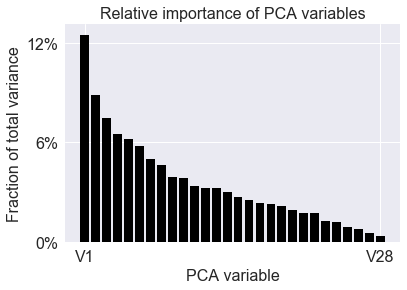

In [3]:
columns_pca = [x for x in dataset.columns if x[0]=='V']
fig = py.figure()
ax = fig.add_subplot(111)
covariance_pca = dataset[columns_pca].cov()
variances = py.diag(covariance_pca)
total_variance = sum(variances)
ax.bar(range(len(variances)),variances/total_variance,width=0.8,color='k')
ax.set_xticks([0,27])
ax.set_xticklabels(['V1','V28'],fontsize=16)
ax.set_xlabel('PCA variable',fontsize=16)
ax.set_yticks([0,0.06,0.12])
ax.set_yticklabels(['0%','6%','12%'],fontsize=16)
ax.set_ylabel('Fraction of total variance',fontsize=16)
ax.set_title('Relative importance of PCA variables',fontsize=16);

Another way to check how much each variable can be important is through their degree of linear correlation with the class variable (legit or fraudulent transaction). Some of the variables show up to 0.3 correlation.

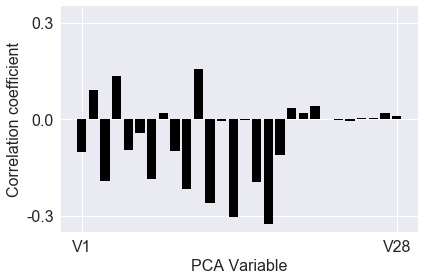

In [4]:
correlation_matrix = dataset[columns_pca+['Class']].corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),(correlation_var),width=0.8,color='k')
ax.set_xticks([0,27])
ax.set_xticklabels(['V1','V28'],fontsize=16)
ax.set_xlabel('PCA Variable',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([-0.3,0,0.3])
ax.set_ylim(-0.35,0.35)
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);
fig.tight_layout()

I can also visualize the projection of the training examples into pairs of PCA variables.

The plots below are promising. It shows that the fraudulent transactions are concentrated and I can hope to find a rule that can separate them from the valid transactions. At the very least, it's likely that a simple model using only V1-V2-V3 can already flag many transactions as very likely to be non-fraudulent.

In [5]:
def plot_PCA_variables(dataset,variableX,variableY,equal=True):
    dataset_valid = dataset[dataset['Class']==0]
    dataset_fraud = dataset[dataset['Class']==1]
    data_x_valid = dataset_valid[variableX]
    data_y_valid = dataset_valid[variableY]
    data_x_fraud = dataset_fraud[variableX]
    data_y_fraud = dataset_fraud[variableY]
    fig = py.figure()
    if equal:
        ax = fig.add_subplot(111,aspect='equal')
    else:
        ax = fig.add_subplot(111)
    ax.scatter(data_x_valid,data_y_valid,marker='.',color='k',label='Legit')
    ax.scatter(data_x_fraud,data_y_fraud,marker='*',color='r',label='Fraud')
    ax.set_xlabel(variableX,fontsize=16)
    ax.set_ylabel(variableY,fontsize=16)
    ax.set_title('2D projection - {:s}-{:s} plane'.format(variableX,variableY),fontsize=16)
    return fig,ax

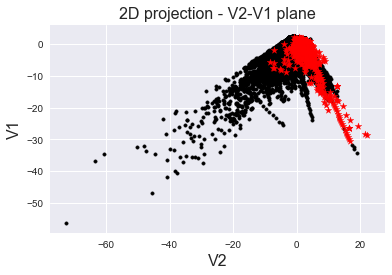

In [6]:
fig,ax = plot_PCA_variables(dataset,'V2','V1')

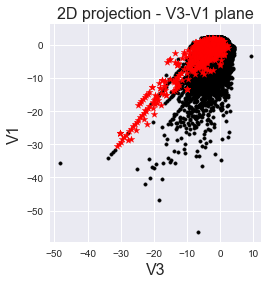

In [7]:
fig,ax = plot_PCA_variables(dataset,'V3','V1')

## Data visualization of variable 'Time'

The data includes two day's worth of transactions, labeled by seconds after the first transaction, which I don't know when it happened. From a histogram, I can infer that this transaction happened in the middle of the night, possibly at midnight of the relevant timezone.

The histogram for legit transactions (shown below in blue) show a clear pattern of day-night, even that the information is not fully present in the dataset. The histogram for fraudulent transactions, on the other hand, do not show quite the same pattern. This can be due to two reasons. One is that the sample size is small, only 500 fraudulent transactions. Another is that the frauds really do not obey the same day-night cycle as the legit transactions.

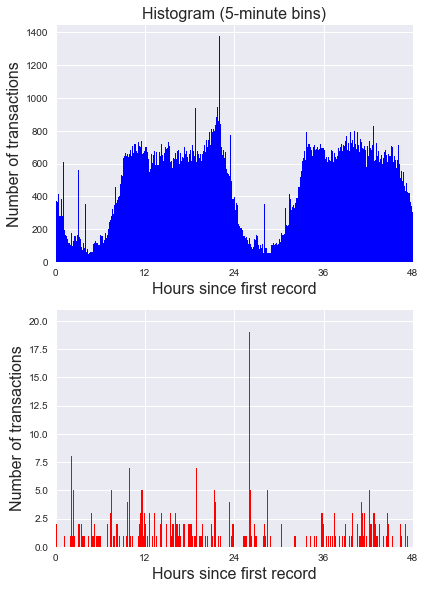

In [8]:
fig = py.figure(figsize=(1*6.4,2*4.8))
ax = fig.add_subplot(211)
n_bins = 48*12
hist_legit_y,hist_legit_x,_ = ax.hist(dataset[dataset['Class']==0]['Time']/3600.,bins=n_bins,color='b',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_title('Histogram (5-minute bins)',fontsize=16)
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);
ax = fig.add_subplot(212)
hist_fraud_y,hist_fraud_x,_ = ax.hist(dataset[dataset['Class']==1]['Time']/3600.,bins=n_bins,color='r',normed=None,range=(0,48));
ax.set_xlabel('Hours since first record',fontsize=16)
ax.set_ylabel('Number of transactions',fontsize=16);
ax.set_xticks([0,12,24,36,48])
ax.set_xlim([0,48]);

## Feature engineering about 'Time'

The influence of the transaction time on the probability of fraud has to be periodic with a period of 24 hours. Other cycles could be possible, such as a seven-day cycle to account for different weekday/weekend patterns, and possibly holidays. However, with only two days of data available, these cycles can not be studied. Because of that, only the time-of-day information should be considered, but not the day.

The influence of time on the probability of fraud is not expected to be linear. As such, if the variable 'Time' is passed to a linear model such as logistic regression, it is likely to have very little predictive power. I need then to transform it to a different set of features that might be better handled to this situation.

There are some ways to deal with a periodic variable. One of them is to break it into intervals and consider one-hot encoding. For example, I could have 24 features that takes values in 0-1 indicating if the transaction happened between midnight and 1am, or between 1am and 2am, and so on. 

However, I think a better approach is to use a set of Fourier coefficients for each transaction. The advantage that it brings is that the functions that can be modelled this way are smoother than what can be modeled by a one-hot bin encoding. To check how many harmonics must be included, I can fit the time histogram with some number of harmonics.

In [9]:
def plot_Fourier_approximation(number_of_harmonics):
    fourier_transform = py.rfft(hist_legit_y)
    n_coefficients = min(2*number_of_harmonics+1,len(fourier_transform))    
    fig = py.figure()
    ax = fig.add_subplot(111)
    width = hist_legit_x[1] - hist_legit_x[0]
    ax.bar(hist_legit_x[:-1],hist_legit_y,width=width)
    size = len(hist_legit_y)
    period = 48
    reconstructed = py.array([fourier_transform[0].real / size for x in hist_legit_x[1:]])
    for harmonics in range(2,n_coefficients,2):
        reconstructed += py.array([fourier_transform[harmonics].real*py.cos(+harmonics * 2*py.pi*x/period)*2/size for x in hist_legit_x[1:]])
        reconstructed += py.array([fourier_transform[harmonics].imag*py.sin(-harmonics * 2*py.pi*x/period)*2/size for x in hist_legit_x[1:]])
    ax.plot(hist_legit_x[1:],reconstructed,'r-')
    ax.set_xlabel('Hours since first record',fontsize=16)
    ax.set_ylabel('Number of transactions',fontsize=16);
    ax.set_title('Fourier approximation ({:d} coefficients)'.format(int(n_coefficients/2)),fontsize=16)



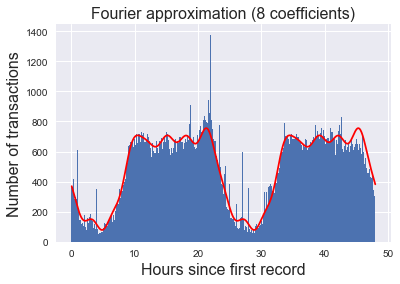

In [10]:
plot_Fourier_approximation(8)

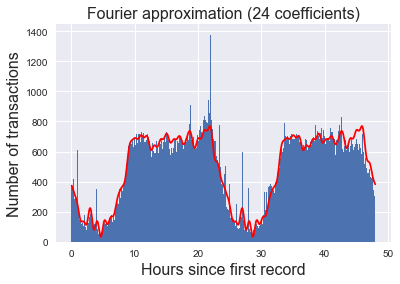

In [11]:
plot_Fourier_approximation(24)

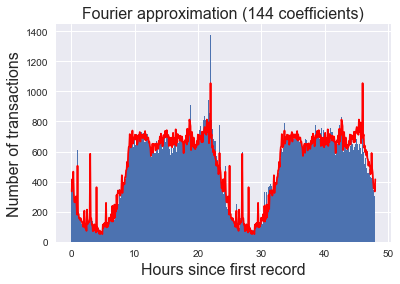

In [12]:
plot_Fourier_approximation(1e10)

Based on these histograms, including eight harmonics seems enough to understand the day-night cycle of credit card transactions. Adding more harmonics probably leads to overfitting, mainly influenced by a surge of activity at a particular time near 10pm on the first day.

This will lead to 16 features being created for each training example.

In [13]:
for column in dataset.columns:
    if 'Time_Fourier_Day' in column:
        dataset.drop(column,axis=1,inplace=True)
n_harmonics = 8
period = 24 * 60 * 60.0
for harmonic in range(1,1+n_harmonics):
    dataset['Time_Fourier_Day_C{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.cos(h*2*py.pi*x/period))
    dataset['Time_Fourier_Day_S{:02d}'.format(harmonic)] = dataset['Time'].apply(lambda x,h=harmonic:py.sin(h*2*py.pi*x/period))

## Data visualization of variable 'Amount'

Like many money variables that are constrained to be positive, the distribution of this variable is highly skewed with a long right tail. Because of that, it's best to consider the logarithm of the value. However, some transactions (about 0.6% of them) are for zero amount. I will replace those values with that of the minimum transaction, $0.01.


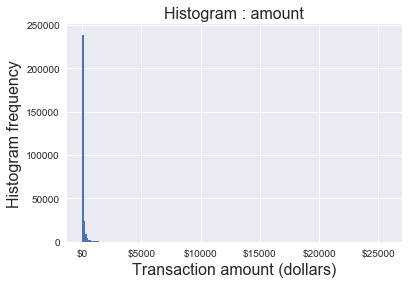

In [14]:
fig = py.figure()
ax = fig.add_subplot(111)
data_y = dataset['Amount']
ax.hist(data_y,bins=200);
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Histogram : amount',fontsize=16);
ax.set_xticklabels(['$'+str(int(x)) for x in ax.get_xticks()]);

In [15]:
dataset['Amount_log'] = dataset['Amount'].apply(lambda x:py.log10(x) if x>0 else py.nan)
dataset['Amount_log'].fillna(min(dataset['Amount_log']),inplace=True)

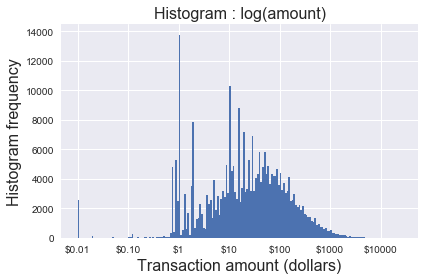

In [16]:
fig = py.figure()
ax = fig.add_subplot(111)
histogram_y,histogram_x,patches = ax.hist(dataset['Amount_log'],bins='auto');
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Histogram : log(amount)',fontsize=16);
ax.set_xticks(range(-2,5))
ax.set_xticklabels(['${:d}'.format(int(10.**x)) if x>=0 else '${:.02f}'.format(10.**x) for x in ax.get_xticks()]);
fig.tight_layout()

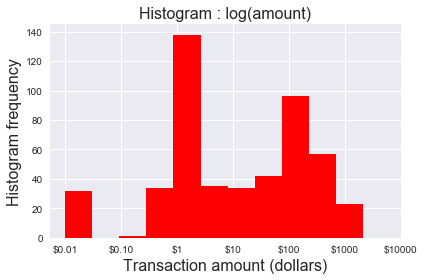

In [17]:
fig = py.figure()
ax = fig.add_subplot(111)
histogram_y,histogram_x,patches = ax.hist(dataset[dataset['Class']==1]['Amount_log'],bins='auto',color='r');
ax.set_xlabel('Transaction amount (dollars)',fontsize=16)
ax.set_ylabel('Histogram frequency',fontsize=16)
ax.set_title('Histogram : log(amount)',fontsize=16);
ax.set_xticks(range(-2,5))
ax.set_xticklabels(['${:d}'.format(int(10.**x)) if x>=0 else '${:.02f}'.format(10.**x) for x in ax.get_xticks()]);
fig.tight_layout()

A good amount of frauds seem to be for exactly one dollar, as can be seen from the absolute frequencies. While 22% of the frauds involved transactions of exactly \$1, only 5% of legit transactions were for \$1 (but this was also the most frequent value).

In [18]:
dataset[dataset['Class']==1]['Amount'].value_counts().head() / len(dataset[dataset['Class']==1])

1.00     0.229675
0.00     0.054878
99.99    0.054878
0.76     0.034553
0.77     0.020325
Name: Amount, dtype: float64

In [19]:
dataset[dataset['Class']==0]['Amount'].value_counts().head() / len(dataset[dataset['Class']==0])

1.00     0.047746
1.98     0.021258
0.89     0.017136
9.99     0.016693
15.00    0.011537
Name: Amount, dtype: float64

## Feature engineering about 'Amount'



The histogram for legit transactions shows a peak envelope with some spikes. To understand these spikes, it's instructive to look at the histogram of the cents part of the amount.

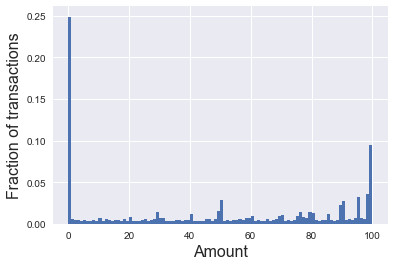

In [20]:
dataset['Amount_cents'] = dataset['Amount'].apply(lambda x:int(round(100*(x%1))))
fig = py.figure()
ax = fig.add_subplot(111)
hist_y,hist_x,_ = ax.hist(dataset['Amount_cents'],bins=100,range=(0,100),normed=1);
ax.set_xlabel('Amount',fontsize=16)
ax.set_ylabel('Fraction of transactions',fontsize=16)

Most transactions involve a whole-dollar amount. There is also some smaller peaks at almost-dollar (values ending in 0.90, 0.98 or 0.99) and also at 0.50. Then, I will create categorical variables to account for these conditions. Because of the previously mentioned fact that many fraudulent transactions are for exactly $1, I will treat this case separately from other whole-dollar amounts.

In [21]:
def categorizeCents(value):
    dollars,cents = divmod(value,1.0)
    cents = int(round(100*cents))
    if value == 1:
        return 'One'
    elif cents in [0]:
        return 'Whole'
    elif cents in [50]:
        return 'Half'
    elif cents in [90,98,99]:
        return 'Almost'
    else:
        return 'Other'
dataset['Amount_centsCategory'] = dataset['Amount'].apply(categorizeCents)

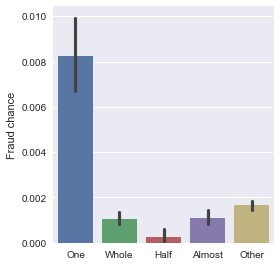

In [22]:
order = ['One','Whole','Half','Almost','Other']
ax = sns.factorplot(x='Amount_centsCategory',y='Class',data=dataset,kind='bar',order=order)
ax.set_axis_labels('','Fraud chance')

In [23]:
dataset[dataset['Class']==0]['Amount_centsCategory'].value_counts()

Other     160811
Whole      57097
Almost     44813
One        13575
Half        8019
Name: Amount_centsCategory, dtype: int64

In [24]:
dataset[dataset['Class']==1]['Amount_centsCategory'].value_counts()

Other     266
One       113
Whole      61
Almost     50
Half        2
Name: Amount_centsCategory, dtype: int64

Transactions for exactly \$1 are more likely to be frauds than others, while transactions for half-dollar amounts (\$0.50, \$1.50, etc) are less likely to be frauds than others.

# Feature selection and normalization

I will consider two classes of models in the analysis. Some models will use only the PCA variables, while others will include these and the engineered features derived from 'Time' and 'Amount'. This is because the PCA variables show a high degree of correlation with the legit/fraud classification, while 'Time' and 'Amount' show a weaker relationship (except for the fact about \$1 transactions).

The categorical variable 'Amount_cents' will be transformed to one-hot encoding.

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 50 columns):
Time                    284807 non-null float64
V1                      284807 non-null float64
V2                      284807 non-null float64
V3                      284807 non-null float64
V4                      284807 non-null float64
V5                      284807 non-null float64
V6                      284807 non-null float64
V7                      284807 non-null float64
V8                      284807 non-null float64
V9                      284807 non-null float64
V10                     284807 non-null float64
V11                     284807 non-null float64
V12                     284807 non-null float64
V13                     284807 non-null float64
V14                     284807 non-null float64
V15                     284807 non-null float64
V16                     284807 non-null float64
V17                     284807 non-null float64
V18                     2

In [26]:
features_amount_cents = pd.get_dummies(dataset['Amount_centsCategory'],prefix='Amount_cents')
features_amount_cents = features_amount_cents.drop('Amount_cents_Other',axis=1)
dataset = dataset.join(features_amount_cents)

In [27]:
columns_pca = [x for x in dataset.columns if x[0]=='V']
columns_all = columns_pca +\
               [x for x in dataset.columns if 'Time_Fourier_Day' in x] +\
               ['Amount_log'] +\
               [x for x in dataset.columns if 'Amount_cents_' in x]               

If the chosen features have very different ranges of values, the models can be slow to converge. It is important to check that the variance of all of them have similar values.

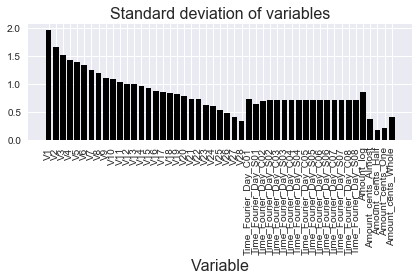

In [28]:
fig = py.figure()
ax = fig.add_subplot(111)
std = dataset[columns_all].describe().loc['std',:]
ax.bar(range(len(std)),std,width=0.8,color='k')
ax.set_xticks(range(len(std)))
ax.set_xticklabels(columns_all,rotation='vertical')
ax.set_xlabel('Variable',fontsize=16)
# ax.set_ylabel('Standard deviation',fontsize=16)
ax.set_title('Standard deviation of variables',fontsize=16)
fig.tight_layout()

There are not huge differences in the standard deviation of all variables. Then no feature normalization needs to take place.

# Creating training and test set

To avoid problems with overfitting, it's important to test a model in a different dataset than it was trained on.

In [29]:
test_ratio = 0.2
dataset_train,dataset_test = sklearn.model_selection.train_test_split(dataset,test_size=test_ratio,random_state=0)

# Modelling 

I will test several models, and also potentially test a stacking model that combines some of the models. I will consider models that only take into account the PCA variables and models that take into account the other variables derived from Time and Amount. 

All models will be stored in the variable 'trained_models' and the predicted probabilities are stored in a Pandas dataframe variable 'predicted_probabilities'.

Each model is trained using the GridSearchCV routine. This uses cross-validation techniques to optimize some hyperparameters about the model. Examples of hyperparameters include the regularization strenght in logistic regression and neural networks, or the size (number of nodes) of a neural network, etc. This optimization is done using the 'average_precision' argument, which is equivalent to the area under the precision-recall curve.

In [30]:
trained_models = {}
predicted_probabilities = pd.DataFrame(index=dataset.index)
scorers = [sklearn.metrics.make_scorer(sklearn.metrics.average_precision_score),
           sklearn.metrics.make_scorer(sklearn.metrics.fbeta_score,beta=5)]
def routine_GridSearchCV(estimator,parameters,dataset,columns,scoring_method=0):
    scoring = scorers[scoring_method]
    grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
    grid.fit(dataset[columns],dataset['Class'])
    best_model = grid.best_estimator_
    return best_model

## Logistic regression

Before trying more 'fancy' models, I will look at a simple logistic regression to serve as a benchmark. A simpler model of the logistic regression will actually only use the PCA variables.

In [31]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-3,3,5))}
label = 'logreg_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca,scoring_method=0)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'logreg_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all,scoring_method=0)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

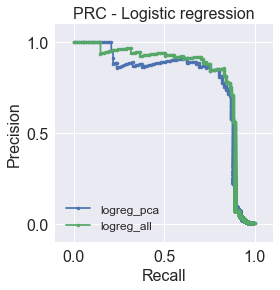

In [32]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['logreg_pca','logreg_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Logistic regression',fontsize=16)

## Naive Bayes method

I am now going to test another very simple model that is very fast computationally. It turns out to be a very naive method, not much helpful.

In [33]:
estimator = sklearn.naive_bayes.GaussianNB()
parameters = {}
label = 'naivebayes_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'naivebayes_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

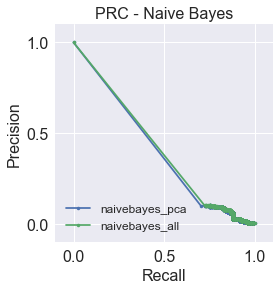

In [34]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['naivebayes_pca','naivebayes_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Naive Bayes',fontsize=16)

## Decision tree classifier

One advantage of this method is that it is possible to know which features the fitted model considers important for the task. I will test two types of trees, with different criterions for optimization.

In [35]:
estimator = sklearn.tree.DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[None,5,10]}
label = 'decisiontree_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'decisiontree_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

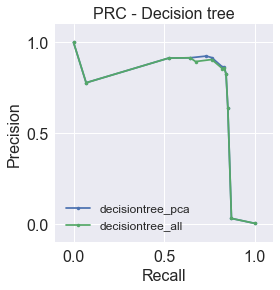

In [36]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['decisiontree_pca','decisiontree_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Decision tree',fontsize=16)

## Random forest classifier

A random forest method uses an averaging of decision trees.

In [37]:
estimator = sklearn.ensemble.RandomForestClassifier()
parameters = {'n_estimators':[5,10],'criterion':['gini','entropy'],'max_depth':[None,5]}
label = 'randomforest_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'randomforest_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

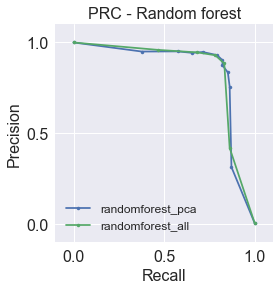

In [38]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['randomforest_pca','randomforest_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Random forest',fontsize=16)

An alternative to random forests provided by sci-kit-learn is the ExtraTrees classifier.

In [39]:
estimator = sklearn.ensemble.ExtraTreesClassifier()
parameters = {'n_estimators':[5,10],'criterion':['gini','entropy'],'max_depth':[None,5]}
label = 'extratrees_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'extratrees_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

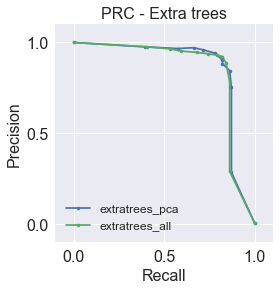

In [40]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['extratrees_pca','extratrees_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Extra trees',fontsize=16)

## Support vector machine

Another popular estimator is a support vector machine. It implements only a prediction method with 0-1 labels, but no probabilities.

There are several possible kernels. Linear kernels have a runtime much faster than nonlinear kernels.

It turns out that Support Vector Machines don't perform well on this dataset. They are more computationally expensive and perform worse than a simple logistic regression.

In [41]:
estimator = sklearn.svm.LinearSVC(class_weight='balanced')
label = 'svmlinear_pca'
estimator.fit(dataset_train[columns_pca],dataset_train['Class'])
trained_models[label] = estimator
predicted_probabilities[label] = trained_models[label].predict(dataset[columns_pca])

In [42]:
# estimator = sklearn.svm.LinearSVC(class_weight='balanced')
# label = 'svmlinear_all'
# estimator.fit(dataset_train[columns_all],dataset_train['Class'])
# trained_models[label] = estimator
# predicted_probabilities[label] = trained_models[label].predict(dataset[columns_all])

In [43]:
estimator = sklearn.svm.SVC(class_weight='balanced')
label = 'svmgeneral_pca'
estimator.fit(dataset_train[columns_pca],dataset_train['Class'])
trained_models[label] = estimator
predicted_probabilities[label] = trained_models[label].predict(dataset[columns_pca])

In [44]:
# estimator = sklearn.svm.SVC(class_weight='balanced')
# label = 'svmgeneral_all'
# estimator.fit(dataset_train[columns_all],dataset_train['Class'])
# trained_models[label] = estimator
# predicted_probabilities[label] = trained_models[label].predict(dataset[columns_all])

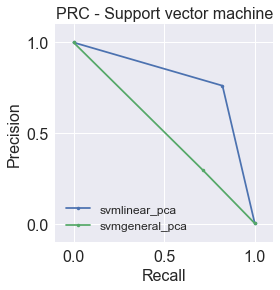

In [45]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['svmlinear_pca','svmgeneral_pca']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Support vector machine',fontsize=16)

## Neural networks

A more sophisticated methods is neural networks.

In [46]:
estimator = sklearn.neural_network.MLPClassifier()
# parameters = {'activation':['relu','tanh','logistic'],'alpha':10**(py.linspace(-5,-3,3)),'hidden_layer_sizes':[(100,),(300,),(500,)]}
parameters = {'activation':['relu','logistic'],'alpha':[10**(-4)],'hidden_layer_sizes':[(100,),(300,)]}
label = 'neuralnet_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'neuralnet_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

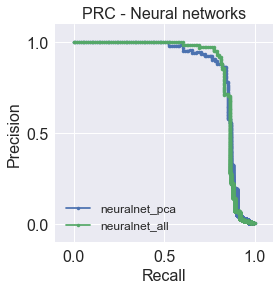

In [47]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['neuralnet_pca','neuralnet_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Neural networks',fontsize=16)

## Deep neural network

A neural network can also have more layers.


In [48]:
estimator = sklearn.neural_network.MLPClassifier()
parameters = {'activation':['relu','logistic'],'alpha':[10**(-4)],'hidden_layer_sizes':[(50,20),(100,30)]}
label = 'neuralnetdeep_pca'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'neuralnetdeep_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,dataset_train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

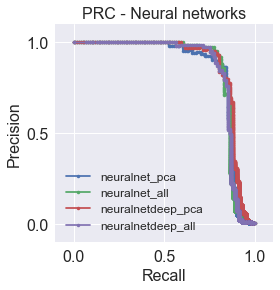

In [49]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['neuralnet_pca','neuralnet_all','neuralnetdeep_pca','neuralnetdeep_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Neural networks',fontsize=16)

## Using polynomial features

The methods used so far showed that adding the features derived from 'Time' and 'Amount' did not significantly improve the performance, and also that more complex models do not show an improvement in the aress of high recall and moderate precision. 

One way to possibly increase the performance is to consider polynomial features of the PCA variables. The number of features is increased to 

In [50]:
polynomial_transformer = {}
polynomial_features = {}

In [51]:
label = 'logreg_polypca'
polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[columns_pca])
trained_models[label] = sklearn.linear_model.LogisticRegression(max_iter=200)
trained_models[label].fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]



# label = 'logreg_polypca'
# polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
# polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[columns_pca])
# estimator = sklearn.linear_model.LogisticRegression(verbose=5,max_iter=200)
# parameters = {'C':10**(py.linspace(-1,1,3))}
# scoring = scorers[0]
# grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
# grid.fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
# trained_models[label] = grid.best_estimator_
# predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]
# label = 'logreg_polypca'
# polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
# polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[columns_pca])
# estimator = sklearn.linear_model.LogisticRegression()
# parameters = {'C':10**(py.linspace(-1,1,3))}
# scoring = scorers[0]
# grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
# grid.fit(polynomial_features[label,dataset_train],dataset_train['Class'])
# trained_models[label] = grid.best_estimator_
# predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features).T[1]

/Users/tiagobatalhao/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


We can also test the performance using only a subset of the PCA variables.

In [52]:
n_components = 5
label = 'logreg_polypca_'+str(n_components)
polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[['V'+str(x) for x in range(1,1+n_components)]])
trained_models[label] = sklearn.linear_model.LogisticRegression(max_iter=200)
trained_models[label].fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]


# estimator = sklearn.linear_model.LogisticRegression()
# parameters = {'C':10**(py.linspace(-1,1,3))}
# scoring = scorers[0]
# grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
# grid.fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
# trained_models[label] = grid.best_estimator_
# predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]

[LibLinear]

In [53]:
n_components = 10
label = 'logreg_polypca_'+str(n_components)
polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[['V'+str(x) for x in range(1,1+n_components)]])
trained_models[label] = sklearn.linear_model.LogisticRegression(max_iter=200)
trained_models[label].fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]


# n_components = 10
# label = 'logreg_polypca_'+str(n_components)
# polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
# polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[['V'+str(x) for x in range(1,1+n_components)]])
# estimator = sklearn.linear_model.LogisticRegression()
# parameters = {'C':10**(py.linspace(-1,1,3))}
# scoring = scorers[0]
# grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
# grid.fit(polynomial_features[label][dataset_train.index],dataset_train['Class'])
# trained_models[label] = grid.best_estimator_
# predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]

[LibLinear]

/Users/tiagobatalhao/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


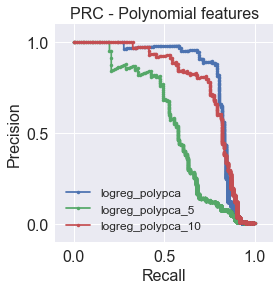

In [55]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['logreg_polypca','logreg_polypca_5','logreg_polypca_10']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Polynomial features',fontsize=16)

Using a smaller subset of PCA variables with polynomial features does not beat the linear model using all PCA variables.

## Naive Bayes with polynomial features

As in the case with linear features, naive Bayes is very fast but poor-performing.

In [56]:
label = 'naivebayes_polypca'
estimator = sklearn.naive_bayes.GaussianNB()
polynomial_transformer[label] = sklearn.preprocessing.PolynomialFeatures(degree=2,include_bias=False)
polynomial_features[label] = polynomial_transformer[label].fit_transform(dataset[columns_pca])
estimator.fit(polynomial_features[label],dataset['Class'])
trained_models[label] = estimator
predicted_probabilities[label] = trained_models[label].predict_proba(polynomial_features[label]).T[1]

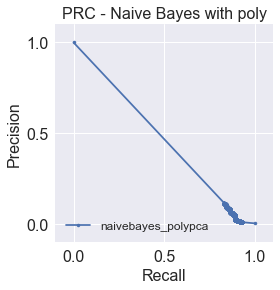

In [57]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['naivebayes_polypca']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Naive Bayes with poly',fontsize=16)

## Undersampling

There is a high degree of imbalance in the dataset, while many classification algorithms are better adapted to classificaation of more balanced datasets. One approach is then to undersample the legit transactions to create a more balanced dataset.

However, this did not show improvement over the models trained on the entire dataset.

In [342]:
def undersample(dataset,fraction=1.0):
    index_fraud = dataset[dataset['Class']==1].index
    index_legit = dataset[dataset['Class']==0].index
    index_legit = numpy.random.choice(index_legit,size=int(fraction*len(index_legit)),replace=False)
    index = list(index_legit) + list(index_fraud)
    numpy.random.shuffle(index)
    return index

In [350]:
estimator = sklearn.neural_network.MLPClassifier(max_iter=1000)
parameters = {'activation':['relu','logistic'],'alpha':[10**(-4)],'hidden_layer_sizes':[(50,20),(100,30)]}
label = 'neuralnet_under1_pca'
train = dataset_train.loc[undersample(dataset_train,0.002)]
trained_models[label] = routine_GridSearchCV(estimator,parameters,train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'neuralnet_under1_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

In [351]:
estimator = sklearn.neural_network.MLPClassifier(max_iter=1000)
parameters = {'activation':['relu','logistic'],'alpha':[10**(-4)],'hidden_layer_sizes':[(50,20),(100,30)]}
label = 'neuralnet_under2_pca'
train = dataset_train.loc[undersample(dataset_train,0.02)]
trained_models[label] = routine_GridSearchCV(estimator,parameters,train,columns_pca)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
label = 'neuralnet_under2_all'
trained_models[label] = routine_GridSearchCV(estimator,parameters,train,columns_all)
predicted_probabilities[label] = trained_models[label].predict_proba(dataset[columns_all]).T[1]

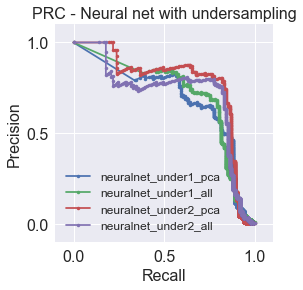

In [352]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in ['neuralnet_under1_pca','neuralnet_under1_all','neuralnet_under2_pca','neuralnet_under2_all']:
    y_predict = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
    ax.plot(recall,precision,'.-',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)
ax.set_title('PRC - Neural net with undersampling',fontsize=16)

# Comparison of models

After training several models, I can compare their performance on a test set, using only examples that were not seen by any model during the training phase. A first way to visualize their performance is through the precision-recall curve, and the models can be scored by the area under that curve.

There's an alternate way of scoring a model, the F_beta score. In the analysis of credit card fraud, recall is more important than precision. This is because a false-positive error (flagging a legit transaction as fraud) bring some inconvenience to the client but a false-negative error (flagging a fraudulent transaction as legit) can bring much more trouble and financial loss. Thus, in the tradeoff between precision and recall that comes when selecting a probability threshold, it's preferrable to increase recall even if it leads to a drop in precision, as long as this drop is not too strong. I chose to use a scorer that attachs five times more importance to a false-negative error as compared to a false-positive error.


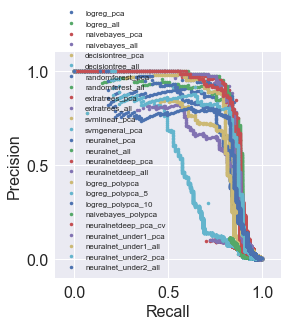

In [356]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in predicted_probabilities.columns:
    if True:
        y_predict = predicted_probabilities.loc[dataset_test.index,label]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
        ax.plot(recall,precision,'.',label=label)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=8)
fig.tight_layout();

In [357]:
scores = {}
for label,model in trained_models.items():
    if label[-4:]=='_pca':
        scores.update({label:scorers[0](model,dataset_test[columns_pca],dataset_test['Class'])})
    if label[-4:]=='_all':
        scores.update({label:scorers[0](model,dataset_test[columns_all],dataset_test['Class'])})
    if 'polypca' in label:
        scores.update({label:scorers[0](model,polynomial_features[label][dataset_test.index],dataset_test['Class'])})

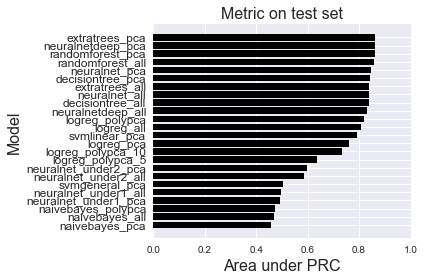

In [358]:
fig = py.figure()
ax = fig.add_subplot(111)
scores_list = sorted([(x,y) for x,y in scores.items()],key=lambda x:-x[1])
labels = [x[0] for x in scores_list]
heights = [x[1] for x in scores_list]
width = 0.8
ax.barh(range(len(heights)),heights,height=width,color='k')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels,fontsize=12);
ax.set_xlim(0,1)
ax.set_xlabel('Area under PRC',fontsize=16)
ax.set_ylabel('Model',fontsize=16)
ax.set_title('Metric on test set',fontsize=16)
ax.invert_yaxis()
fig.tight_layout()

In [359]:
scores_fbeta = {}
beta = 5.0
for label,model in trained_models.items():
    y_true = dataset_test['Class']
    y_predict_proba = predicted_probabilities.loc[dataset_test.index,label]
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict_proba)
#     score_this = max([sklearn.metrics.fbeta_score(y_true,y_predict_proba>thres,beta=5) for thres in threshold])
    scores_fbeta[label] = max([(1+beta**2)*p*r/(beta**2*p+r) for p,r in zip(precision,recall)])
# scores_fbeta.update({label:scorers[1](model,dataset_test[columns_pca],dataset_test['Class']) for label,model in trained_models.items() if label[-3:]=='pca'})
# scores_fbeta.update({label:scorers[1](model,dataset_test[columns_all],dataset_test['Class']) for label,model in trained_models.items() if label[-3:]=='all'})

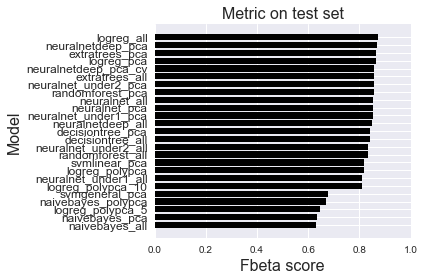

In [360]:
fig = py.figure()
ax = fig.add_subplot(111)
scores_list = sorted([(x,y) for x,y in scores_fbeta.items()],key=lambda x:-x[1])
labels = [x[0] for x in scores_list]
heights = [x[1] for x in scores_list]
width = 0.8
ax.barh(range(len(heights)),heights,height=width,color='k')
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels,fontsize=12);
ax.set_xlim(0,1)
ax.set_xlabel('Fbeta score',fontsize=16)
ax.set_ylabel('Model',fontsize=16)
ax.set_title('Metric on test set',fontsize=16)
ax.invert_yaxis()
fig.tight_layout()

There is not one clear best choice. Several models show very similar behaviour.



# Stacking models

There is no clear winner from all the models that were tested. In this case, there can be room for improvement by considering the predictions that each model makes as features for another model.

In [361]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-2,2,5))}
stacking_train = predicted_probabilities.loc[dataset_train.index]
stacking_model = routine_GridSearchCV(estimator,parameters,stacking_train.join(dataset['Class']),stacking_train.columns)
stacking_probabilities = stacking_model.predict_proba(predicted_probabilities).T[1]

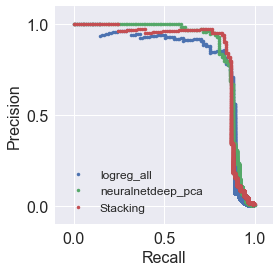

In [362]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
y_true = dataset_test['Class']
for label in predicted_probabilities.columns:
    if label in ['neuralnetdeep_pca','logreg_all']:
        y_predict = predicted_probabilities.loc[dataset_test.index,label]
        precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
        ax.plot(recall,precision,'.',label=label)
y_predict = stacking_probabilities[dataset_test.index]
precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
ax.plot(recall,precision,'.',label='Stacking')

ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.legend(loc='lower left',fontsize=12)

Stacking did not improve the classification performance. One reason for that is that all models behave very similarly, misclassifying the same examples. The strenghts and weaknesses of all models are similar and thus combining them does not improve the predictive power.

# Adjusting threshold

Precision and recall can be changed along the PR curve by adjusting the probability threshold to declare a transaction as fraudulent. 

However, I do not want to use the test set to determine the threshold, as the test set must be used only for evaluating metrics. I need then to separate the training set into a proper training set and a cross-validation set.
I will then re-train the model on this (reduced) training set, choose the threshold using the cross-validation set, and then evaluate metrics on the test set.

In [78]:
test_ratio = 0.2
dataset_train2,dataset_cv = sklearn.model_selection.train_test_split(dataset_train,test_size=test_ratio,random_state=0)

In [105]:
label_old = 'neuralnetdeep_pca'
label_new = 'neuralnetdeep_pca_cv'
trained_models[label_new] =  sklearn.base.clone(trained_models[label_old])
trained_models[label_new].fit(dataset_train2[columns_pca],dataset_train2['Class'])
predicted_probabilities[label_new] = trained_models[label_new].predict_proba(dataset[columns_pca]).T[1]

The relevant part of the precision-recall curve is

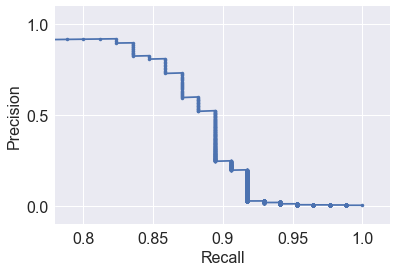

In [106]:
fig = py.figure()
ax = fig.add_subplot(111)
y_true = dataset_cv['Class']
y_predict = predicted_probabilities[label_new][dataset_cv.index]
precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
ax.plot(recall,precision,'.-')
ax.set_xlim(0.78,1.02)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0.8,0.85,0.9,0.95,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16);

The step-like nature of the graph happens because of the small number of fraudulent transactions in the test dataset.

The optimal performance depends on the relative importance given to precision and recall. To choose a threshold, the following graph may be helpful.

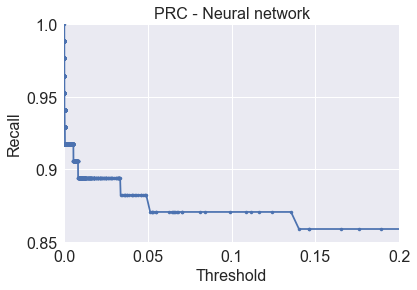

In [109]:
fig = py.figure()
ax = fig.add_subplot(111)
y_true = dataset_cv['Class']
y_predict = trained_models[label_new].predict_proba(dataset_cv[columns_pca]).T[1]
precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
ax.plot(threshold,recall[:-1],'.-')
ax.set_xlim(0,0.2)
ax.set_ylim(0.85,1.0)
ax.set_xticks([0.0,0.05,0.1,0.15,0.2])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0.85,0.9,0.95,1.0])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16)
ax.set_xlabel('Threshold',fontsize=16)
ax.set_ylabel('Recall',fontsize=16);
ax.set_title('PRC - Neural network',fontsize=16);

# Visualization of best model

I can visualize the performance by investigating the types of transactions that lead to a false positive or a false negative. Before doing that, a threshold must be selected.

In [386]:
label = 'neuralnetdeep_pca_cv'
y_true = dataset_cv['Class']
y_predict = trained_models[label].predict_proba(dataset_cv[columns_pca]).T[1]
precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_true,y_predict)
prc = [(x,y,z) for x,y,z in zip(precision,recall,threshold)]
def get_threshold(recall_level):
    try:
        return max([x[2] for x in prc if x[1]>recall_level])
    except ValueError:
        return None
def get_prediction(recall_level):
    threshold = get_threshold(recall_level)
    if threshold is not None:
        prediction = predicted_probabilities['logreg_polypca']>threshold
        return prediction

In [387]:
recall_level = 0.85
threshold = get_threshold(recall_level)
confusion_matrix = sklearn.metrics.confusion_matrix(dataset_test['Class'],get_prediction(recall_level)[dataset_test.index])
print(confusion_matrix)

[[56843    18]
 [   20    81]]


In [388]:
best_prediction = pd.DataFrame(index=dataset.index)
best_prediction['Class'] = dataset['Class']
best_prediction['Prob'] = trained_models[label].predict_proba(dataset[columns_pca]).T[1]
best_prediction['Prediction'] = best_prediction['Prob'].apply(lambda x: 1 if x>threshold else 0)
cases_tn = best_prediction[(best_prediction['Class']==0)&(best_prediction['Prediction']==0)]
cases_fn = best_prediction[(best_prediction['Class']==1)&(best_prediction['Prediction']==0)]
cases_tp = best_prediction[(best_prediction['Class']==1)&(best_prediction['Prediction']==1)]
cases_fp = best_prediction[(best_prediction['Class']==0)&(best_prediction['Prediction']==1)]

I can make visualization plots of the PCA variables, classifying the examples according to the confusion matrix.

In [396]:
def plot_PCA_results(variableX,variableY):
    fig = py.figure(figsize=(2*6.4,4.8))
    cases = [cases_tn,cases_tp,cases_fp,cases_fn]
    colors = ['k','g','y','r']
    alphas = [0.01,1,1,1]
    labels = ['TN','TP','FP','FN']
    ax_train = fig.add_subplot(121)
    for case,color,alpha,label in zip(cases,colors,alphas,labels):
        index = [x for x in case.index if x in dataset_train.index]
        data_x = dataset.loc[index,variableX]
        data_y = dataset.loc[index,variableY]
        ax_train.scatter(data_x,data_y,s=6,color=color,alpha=alpha,label=label)
    ax_test = fig.add_subplot(122)
    for case,color,alpha,label in zip(cases,colors,alphas,labels):
        index = [x for x in case.index if x in dataset_test.index]
        data_x = dataset.loc[index,variableX]
        data_y = dataset.loc[index,variableY]
        ax_test.scatter(data_x,data_y,s=6,color=color,alpha=alpha,label=label)
        
    describe = dataset.describe() 
    x_range = [describe[variableX]['mean']+x*describe[variableX]['std'] for x in [-10,10]]
    y_range = [describe[variableY]['mean']+x*describe[variableY]['std'] for x in [-10,10]]
    for ax in [ax_train,ax_test]:
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.set_xlabel(variableX,fontsize=16)
        ax.set_ylabel(variableY,fontsize=16)
        ax.legend(fontsize=16)
    ax_train.set_title('Training dataset',fontsize=16)
    ax_test.set_title('Test dataset',fontsize=16)

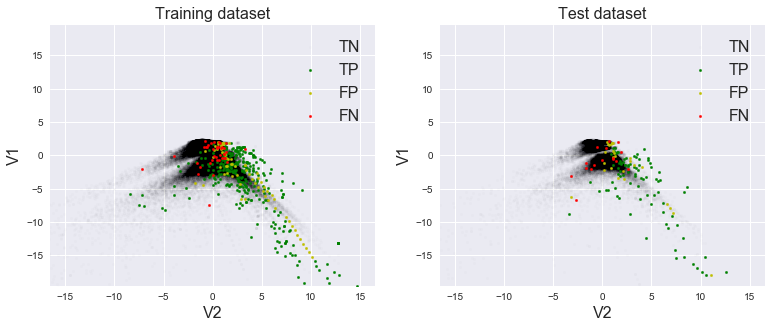

In [397]:
plot_PCA_results('V2','V1')

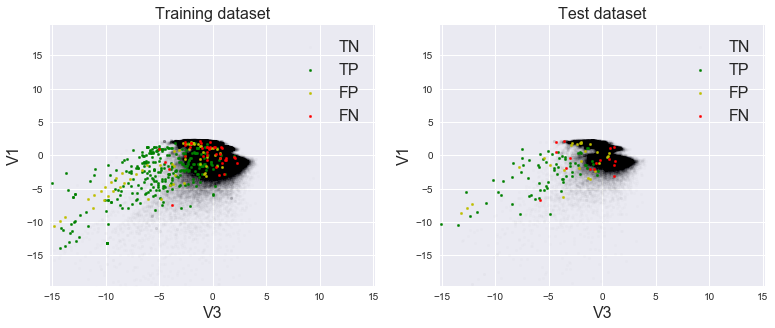

In [398]:
plot_PCA_results('V3','V1')

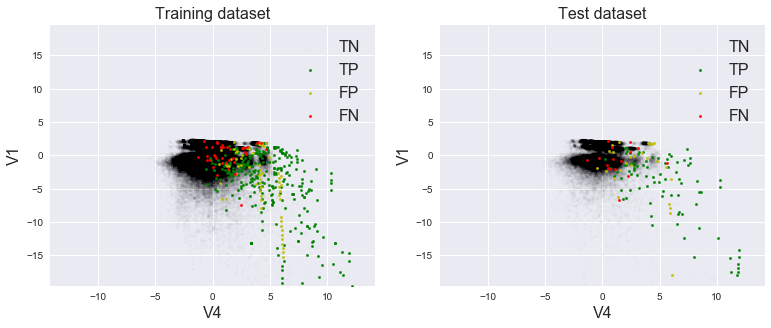

In [399]:
plot_PCA_results('V4','V1')

These plots show some general features of the classification task. Most legit transactions form a big cluster in the space of PCA variables, and the transactions that fall outside this cluster are classified as fraudulent (as most of them actually are fraudulent). On the other hand, the big cluster also contains some fraudulent transactions, which are not detected unless the number of false-positives is allowed to be quite high.